# Data Pre-Processing
<br>
This notebook is used to load, explore and process the raw data into a RL dataset for the environment.

In [1]:
#Import libraries

import pandas as pd
import pandas_market_calendars as mcal
import ta
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

## Load the Raw data
<br>
The raw data purchased comes in two separate csvs that need to be loaded and merged.

In [2]:
#Read Raw Data for SPX500: S&P 500

file1 = 'Raw Data/SPX_2004_2019.csv'
header = ['Timestamp', 'Open', 'High', 'Low', 'Close']
df1 = pd.read_csv(file1, names=header, parse_dates = ['Timestamp'], infer_datetime_format=True)
print (df1.dtypes)
print (df1.shape)
df1.head(5)

Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
dtype: object
(1512711, 5)


,Timestamp,Open,High,Low,Close
0,2004-09-06 09:31:00,1114.42,1114.42,1114.42,1114.42
1,2004-09-06 09:32:00,1114.75,1114.75,1114.65,1114.65
2,2004-09-06 09:33:00,1114.65,1114.65,1114.65,1114.65
3,2004-09-06 09:34:00,1114.65,1114.65,1114.65,1114.65
4,2004-09-06 09:35:00,1114.65,1114.65,1114.65,1114.65


In [3]:
# Need to localize the timezone for the timestamps to New York (obvious why below)

df1.Timestamp = df1.Timestamp.dt.tz_localize('America/New_York')
df1.head(5)

,Timestamp,Open,High,Low,Close
0,2004-09-06 09:31:00-04:00,1114.42,1114.42,1114.42,1114.42
1,2004-09-06 09:32:00-04:00,1114.75,1114.75,1114.65,1114.65
2,2004-09-06 09:33:00-04:00,1114.65,1114.65,1114.65,1114.65
3,2004-09-06 09:34:00-04:00,1114.65,1114.65,1114.65,1114.65
4,2004-09-06 09:35:00-04:00,1114.65,1114.65,1114.65,1114.65


In [4]:
df1.describe()

,Open,High,Low,Close
count,1.512711e+06,1.512711e+06,1.512711e+06,1.512711e+06
mean,1.702321e+03,1.702574e+03,1.702093e+03,1.702297e+03
std,6.003435e+02,6.003991e+02,6.003335e+02,6.002975e+02
min,6.667900e+02,6.672000e+02,6.666700e+02,6.667400e+02
25%,1.239700e+03,1.239930e+03,1.239520e+03,1.239720e+03
50%,1.452040e+03,1.452220e+03,1.451800e+03,1.452050e+03
75%,2.094520e+03,2.094750e+03,2.094310e+03,2.094520e+03
max,3.247750e+03,3.247930e+03,3.247200e+03,3.247650e+03


## Explore the data
<br>
Plotting the data in order to look for any odd things that need to be processed out.

In [5]:
df1.plot(x='Timestamp', y=['Open', 'High', 'Low', 'Close'], subplots=True, figsize=(15,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x124c18cc0>,
      dtype=object)

Error in callback <function flush_figures at 0x120a04488> (for post_execute):


KeyboardInterrupt: 

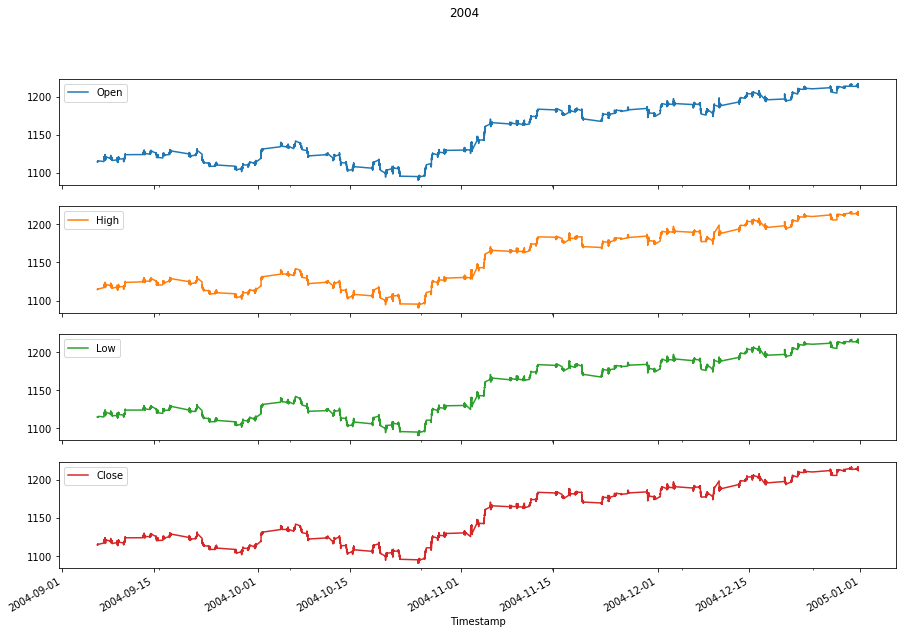

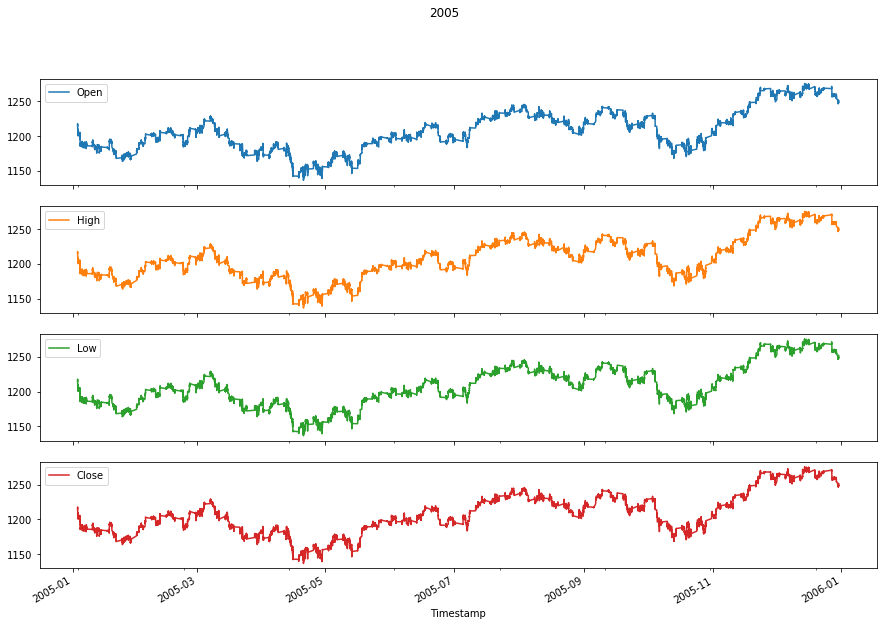

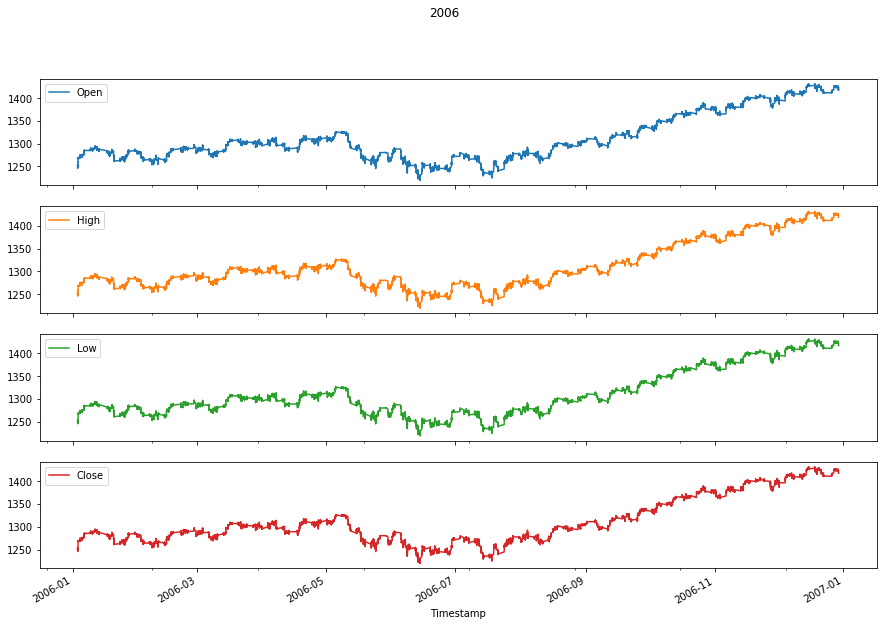

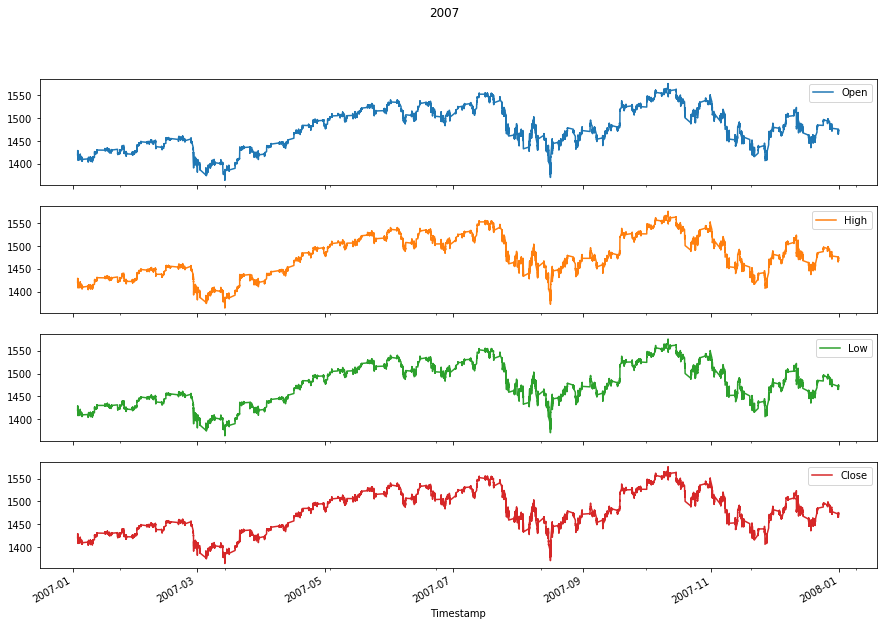

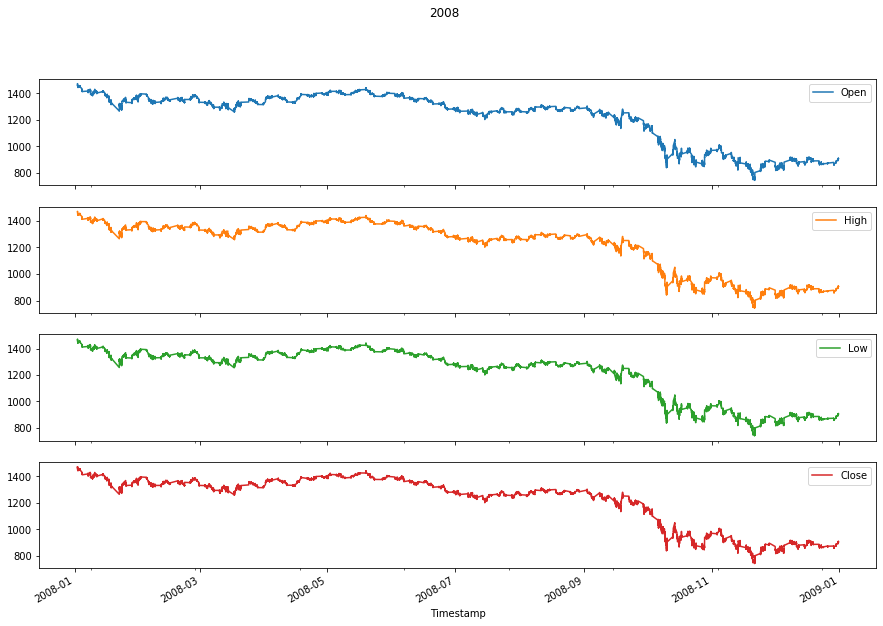

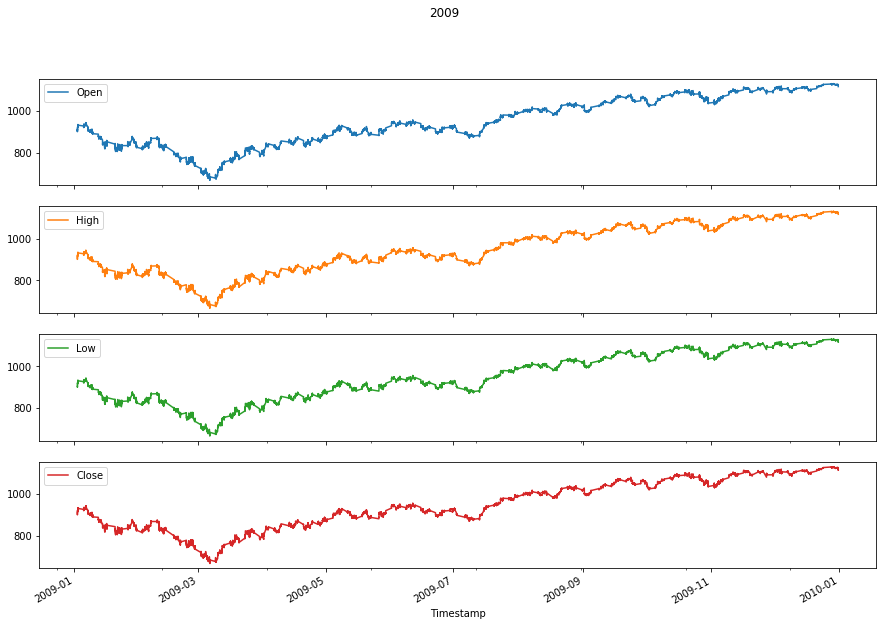

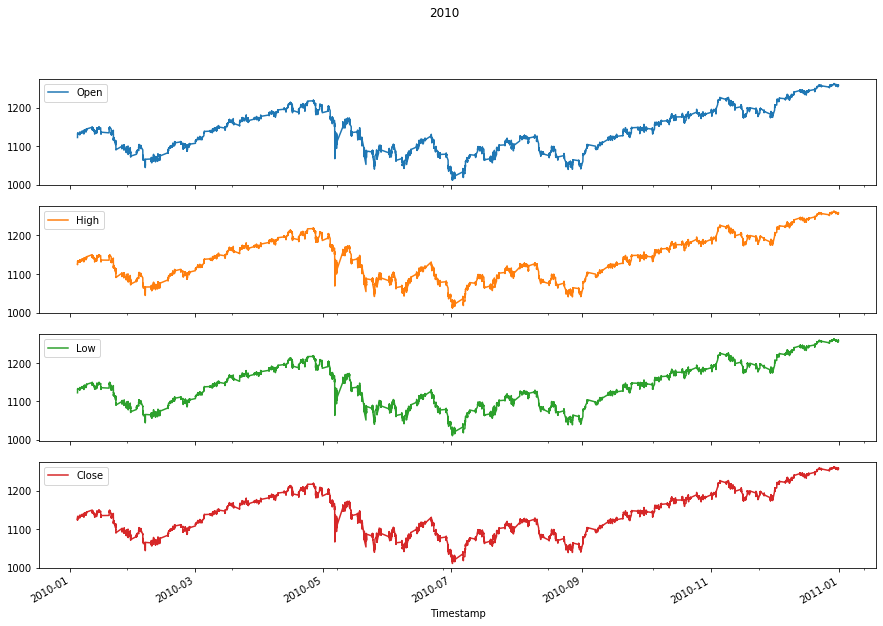

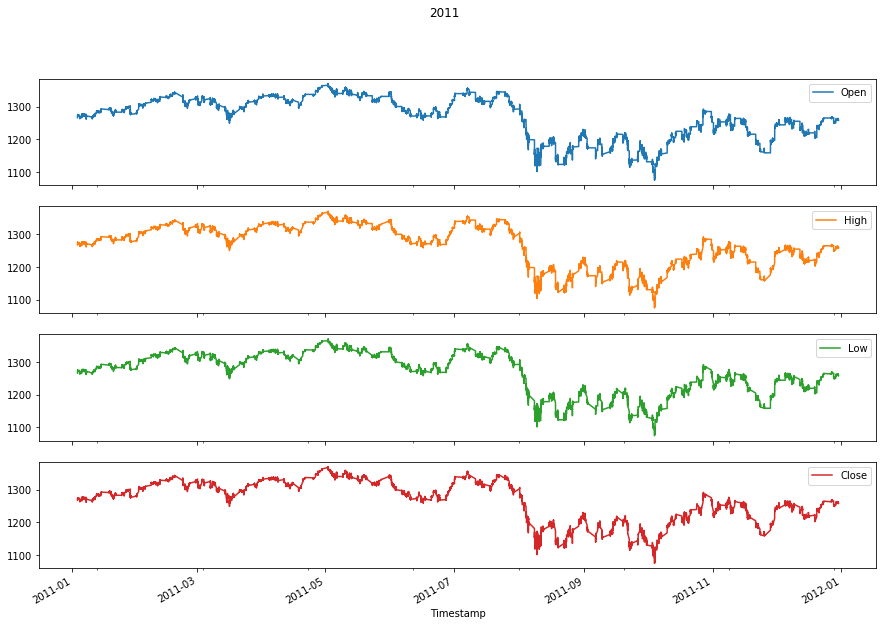

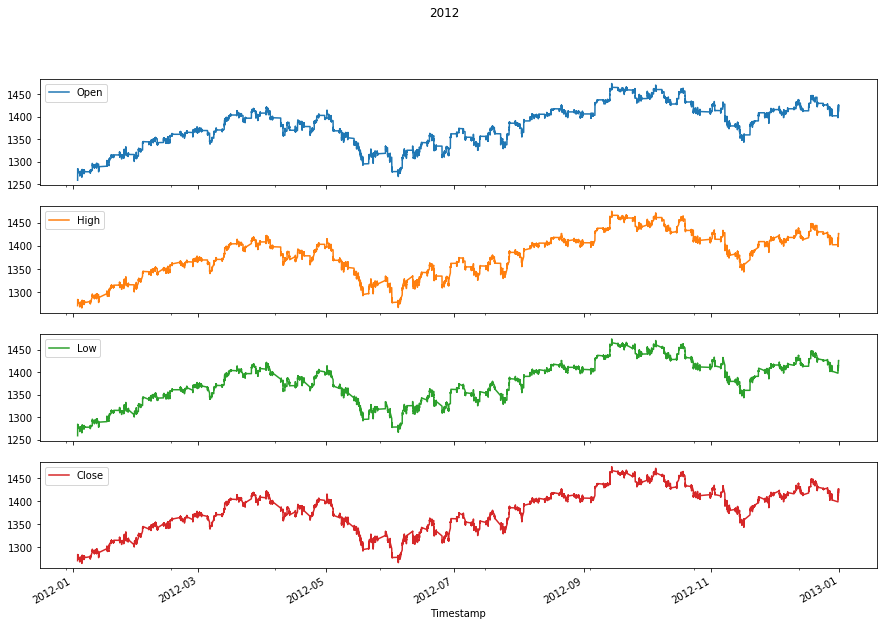

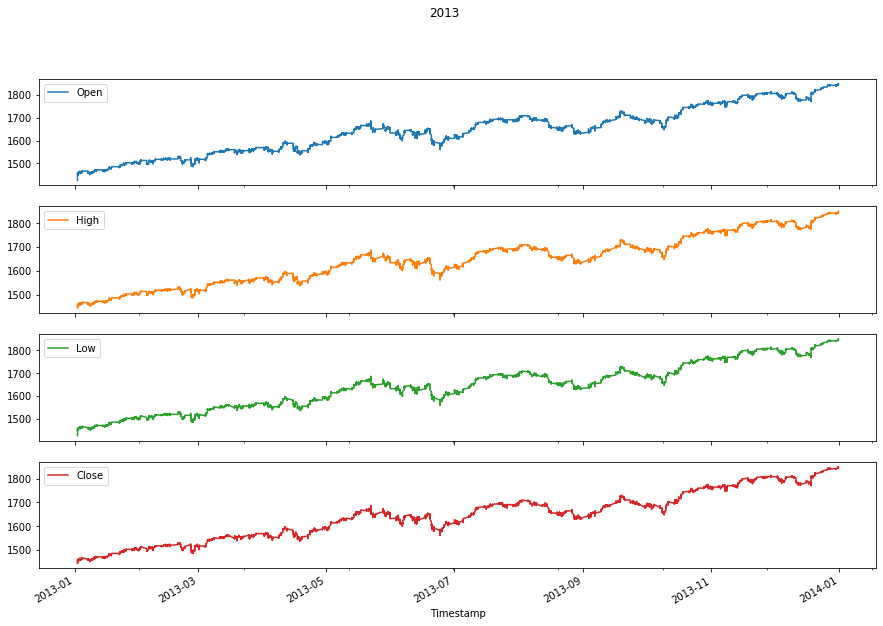

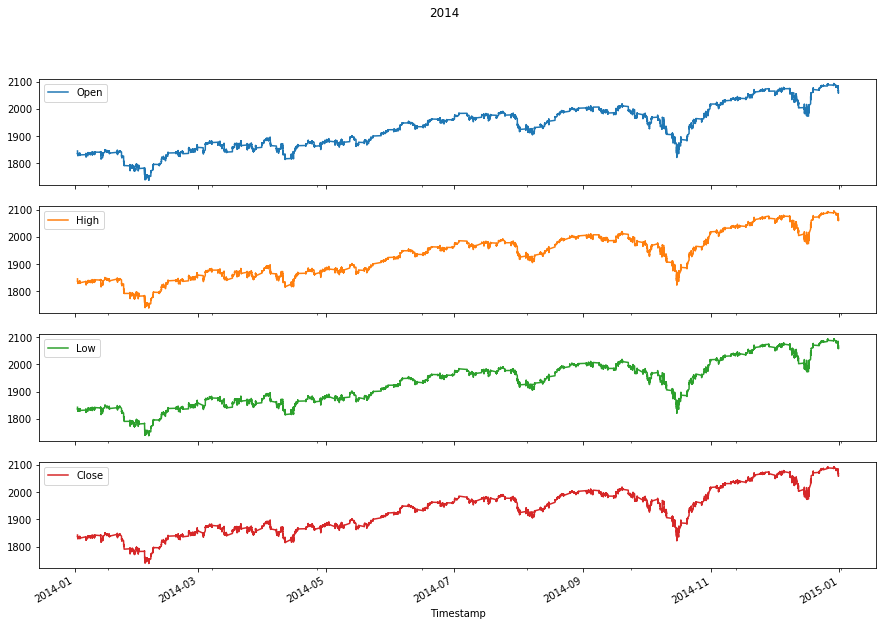

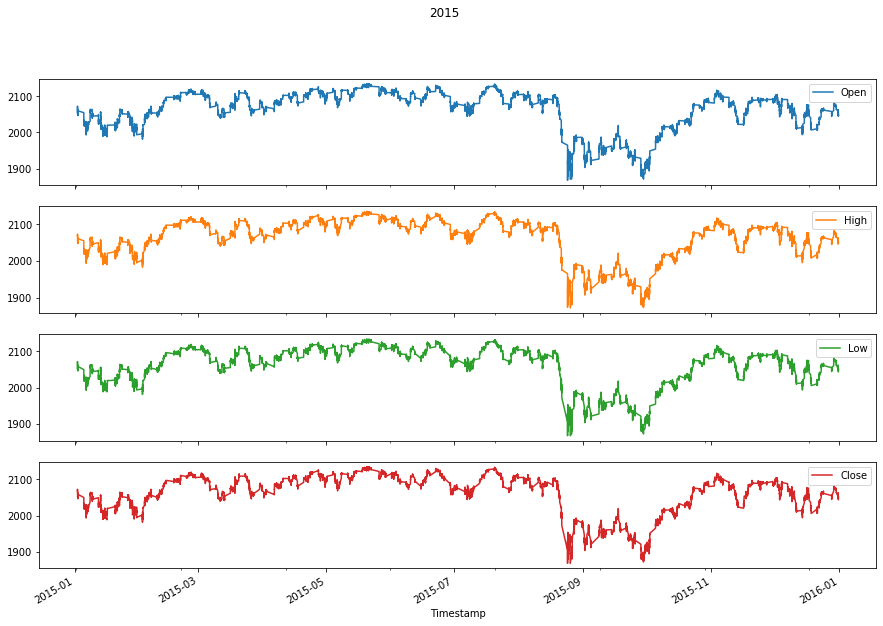

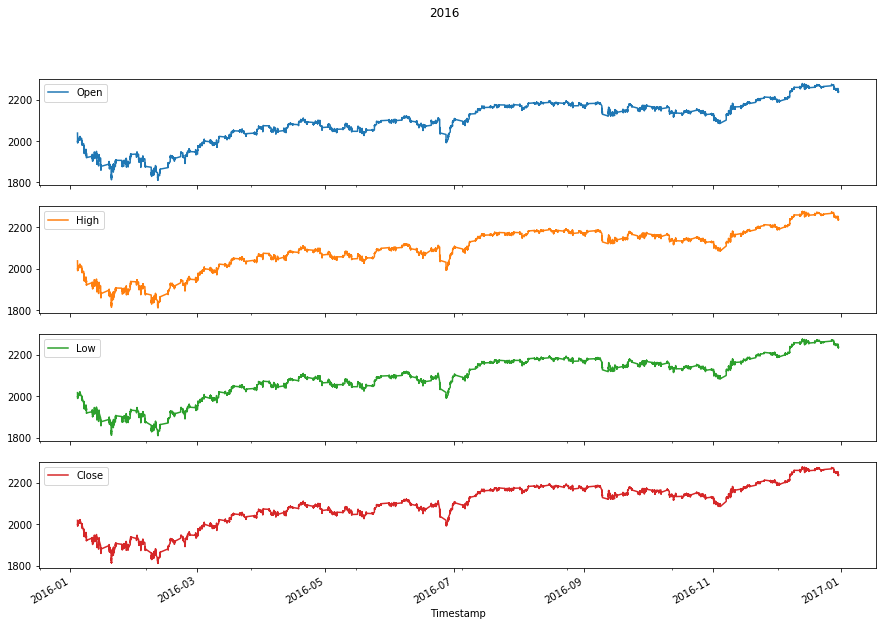

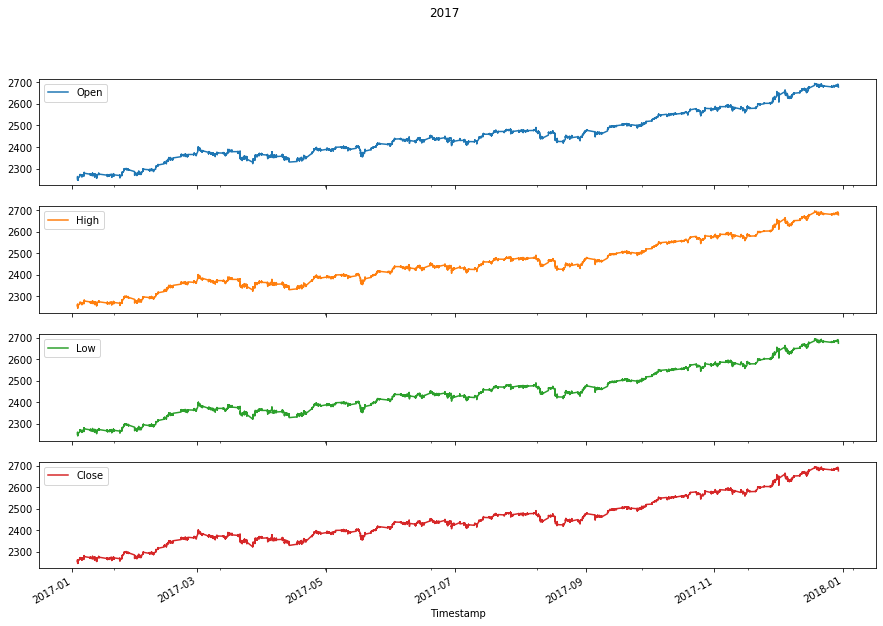

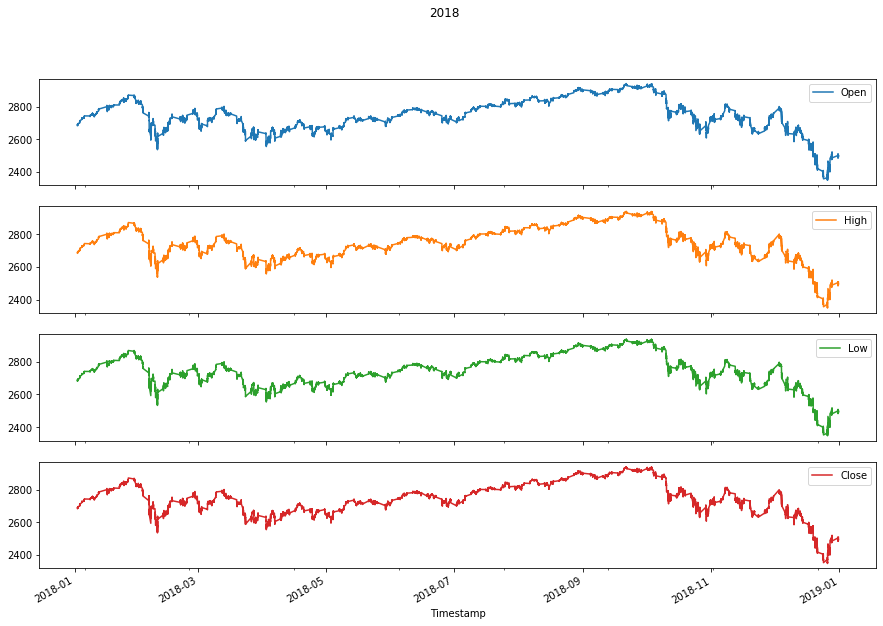

Error in callback <function flush_figures at 0x120a04488> (for post_execute):


KeyboardInterrupt: 

In [6]:
for i in np.arange(2004, 2020, 1):
    df = df1[(df1.Timestamp < str(i+1)+'-01-01') & (df1.Timestamp >= str(i)+'-01-01')]
    df.plot(x='Timestamp',
            y=['Open', 'High', 'Low', 'Close'],
            subplots=True, 
            title=i,
            figsize=(15,10))

### Observations
* I don't see anything weird here.
* Just need to check whether any timesteps are skipped or not. Probably easier to run the trading calendar and filter that way.

## Data Wrangling
### 1. Missing timestamps
I need to fill in all missing timestamps in the dataset. I'll do this using a merge_asf to just copy the nearest row across. Later I'll set the volume to zero for those timestamps.
In order to do this, I've:
* Created a market calendar for the period in question
* Turned that market calendar into a datetimeindex for an empty dataframe
* Used merge_asof to merge and fill the data from df3 above
* Set all "filled" timestamps Volume = 0

In [8]:
# Create the NYSE market calendar using the pandas_market_calendars library

#https://pypi.org/project/pandas-market-calendars/
#https://pandas-market-calendars.readthedocs.io/en/latest/usage.html#setup-new-exchange-calendar

nyse = mcal.get_calendar('NYSE')
start = '2004-09-05'
end = '2019-12-31'
early = nyse.schedule(start_date=start, end_date=end)
ts = mcal.date_range(early, frequency='1min').tz_convert('America/New_York')

In [9]:
# Create an empty dataframe from the datetimeindex above

empty = ts.to_frame()
#empty['Open'], empty['High'], empty['Low'], empty['Close'], empty['Volume'] = 0.0,0.0,0.0,0.0,0
empty.rename(columns={0:'Timestamp'}, inplace=True)
print (empty.dtypes)
empty.head(5)

Timestamp    datetime64[ns, America/New_York]
dtype: object


,Timestamp
2004-09-07 09:31:00-04:00,2004-09-07 09:31:00-04:00
2004-09-07 09:32:00-04:00,2004-09-07 09:32:00-04:00
2004-09-07 09:33:00-04:00,2004-09-07 09:33:00-04:00
2004-09-07 09:34:00-04:00,2004-09-07 09:34:00-04:00
2004-09-07 09:35:00-04:00,2004-09-07 09:35:00-04:00


In [10]:
# Merge_asof the two dataframes to fill in all timestamps

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html

full = pd.merge_asof(empty, df1, on='Timestamp', direction='nearest')
print ('Length of full dataframe: '+str(len(full)))
print ('Length of the original dataframe: '+str(len(df1)))
full.head(10)

Length of full dataframe: 1498110
Length of the original dataframe: 1512711


,Timestamp,Open,High,Low,Close
0,2004-09-07 09:31:00-04:00,1117.10,1119.11,1117.10,1119.11
1,2004-09-07 09:32:00-04:00,1119.02,1119.28,1119.02,1119.28
2,2004-09-07 09:33:00-04:00,1119.37,1119.86,1119.37,1119.86
3,2004-09-07 09:34:00-04:00,1119.95,1120.46,1119.95,1120.46
4,2004-09-07 09:35:00-04:00,1120.55,1120.99,1120.55,1120.99
5,2004-09-07 09:36:00-04:00,1121.08,1121.08,1120.99,1120.99
6,2004-09-07 09:37:00-04:00,1120.91,1120.91,1120.66,1120.66
7,2004-09-07 09:38:00-04:00,1120.57,1120.57,1120.48,1120.48
8,2004-09-07 09:39:00-04:00,1120.40,1120.58,1120.40,1120.58
9,2004-09-07 09:40:00-04:00,1120.66,1120.66,1120.49,1120.57


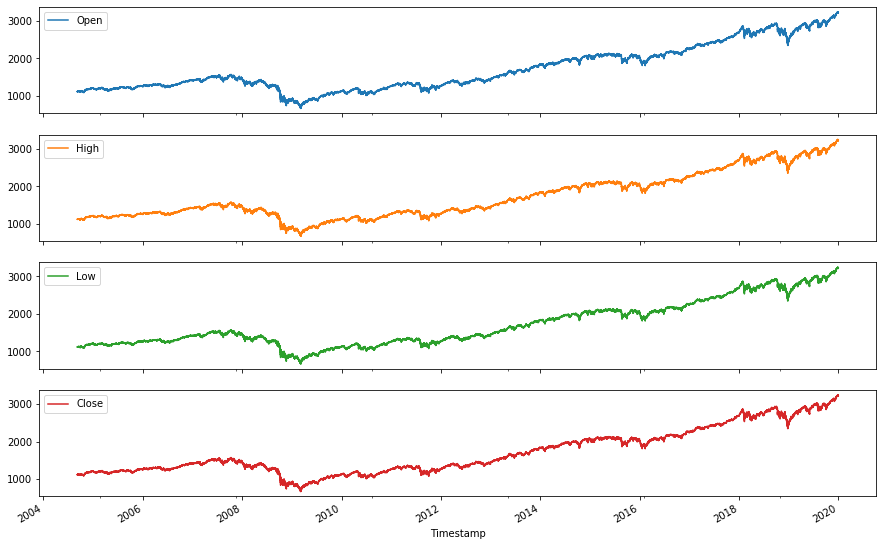

In [11]:
# Plot the new dataframe with all the timestamps filled in

if True:
    full.plot(x='Timestamp', y=['Open', 'High', 'Low', 'Close'], subplots=True, figsize=(15,10))

## Create the hour and day datasets

In [12]:
#http://benalexkeen.com/resampling-time-series-data-with-pandas/

source = full.copy()
source.set_index('Timestamp', inplace=True)
source.head(5)

,Open,High,Low,Close
Timestamp,,,,
2004-09-07 09:31:00-04:00,1117.10,1119.11,1117.10,1119.11
2004-09-07 09:32:00-04:00,1119.02,1119.28,1119.02,1119.28
2004-09-07 09:33:00-04:00,1119.37,1119.86,1119.37,1119.86
2004-09-07 09:34:00-04:00,1119.95,1120.46,1119.95,1120.46
2004-09-07 09:35:00-04:00,1120.55,1120.99,1120.55,1120.99


In [13]:
day = pd.DataFrame()
day['Open'] = source.Open.resample('D').first()
day['High'] = source.High.resample('D').max()
day['Low'] = source.Low.resample('D').min()
day['Close'] = source.Close.resample('D').last()
#day.head(50)
print ('There are',len(day),'calendar days in the dataset.')

There are 5594 calendar days in the dataset.


In [14]:
#Need to drop all rows with NaN as it has added all the non-trading days back in with NaNs

day.dropna(inplace=True)
day.reset_index(inplace=True)
print ('There are',len(day),'trading days in the dataset.')
day.head(10)

There are 3857 trading days in the dataset.


,Timestamp,Open,High,Low,Close
0,2004-09-07 00:00:00-04:00,1117.10,1124.07,1116.23,1121.19
1,2004-09-08 00:00:00-04:00,1119.31,1123.02,1116.30,1116.31
2,2004-09-09 00:00:00-04:00,1117.72,1121.32,1113.56,1118.07
3,2004-09-10 00:00:00-04:00,1117.07,1125.28,1114.37,1123.83
4,2004-09-13 00:00:00-04:00,1123.84,1129.79,1123.33,1125.42
5,2004-09-14 00:00:00-04:00,1125.56,1129.47,1124.74,1128.39
6,2004-09-15 00:00:00-04:00,1125.52,1126.21,1119.70,1120.25
7,2004-09-16 00:00:00-04:00,1120.76,1126.01,1120.76,1123.48
8,2004-09-17 00:00:00-04:00,1125.59,1130.50,1124.15,1128.71
9,2004-09-20 00:00:00-04:00,1124.35,1126.83,1120.30,1122.37


In [15]:
#Same procedure for hours

hour = pd.DataFrame()
hour['Open'] = source.Open.resample('H').first()
hour['High'] = source.High.resample('H').max()
hour['Low'] = source.Low.resample('H').min()
hour['Close'] = source.Close.resample('H').last()
#hour.head(50)
print ('There are',len(hour),'hours in the dataset.')

There are 134241 hours in the dataset.


In [16]:
#Need to drop all rows with NaN as it has added all the non-trading days back in with NaNs

hour.dropna(inplace=True)
hour.reset_index(inplace=True)
print ('There are',len(hour),'hours in the dataset.')
hour.head(10)

There are 30754 hours in the dataset.


,Timestamp,Open,High,Low,Close
0,2004-09-07 09:00:00-04:00,1117.10,1121.08,1117.10,1119.92
1,2004-09-07 10:00:00-04:00,1120.01,1121.13,1117.73,1118.15
2,2004-09-07 11:00:00-04:00,1118.07,1120.69,1118.07,1119.91
3,2004-09-07 12:00:00-04:00,1119.83,1123.03,1119.83,1122.94
4,2004-09-07 13:00:00-04:00,1122.94,1124.07,1121.06,1121.06
5,2004-09-07 14:00:00-04:00,1121.15,1121.41,1116.23,1118.04
6,2004-09-07 15:00:00-04:00,1118.04,1121.47,1117.64,1121.19
7,2004-09-07 16:00:00-04:00,1121.19,1121.19,1121.19,1121.19
8,2004-09-08 09:00:00-04:00,1119.31,1120.88,1118.49,1119.60
9,2004-09-08 10:00:00-04:00,1119.52,1123.02,1118.58,1119.34


## Add the Technical Indicators using the TA library
Some clever folks have published this library which can easily add technical indicators to OHLCV datasets. This is exactly what we need for this job. As per the Proposal, I'll add the following:
* SMA
* EMA
* RSI
* ROC
* MACD
* WO
* ATR

### Simple Moving Average

In [17]:
#Rolling Mean of Close Price

full['SMA_10'] = full['Close'].rolling(10*60*8).mean()
full['SMA_50'] = full['Close'].rolling(50*60*8).mean()
#full.head(75)

day['SMA_10'] = day['Close'].rolling(10).mean()
day['SMA_50'] = day['Close'].rolling(50).mean()
#day.head(75)

hour['SMA_10'] = hour['Close'].rolling(10*8).mean()
hour['SMA_50'] = hour['Close'].rolling(50*8).mean()
#hour.head(75)

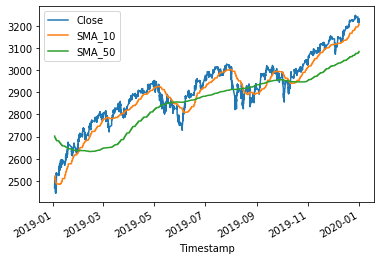

In [18]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'SMA_10', 'SMA_50'])

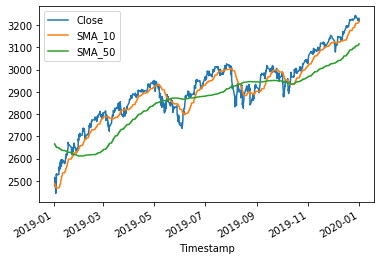

In [19]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'SMA_10', 'SMA_50'])

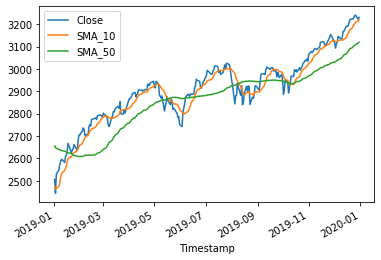

In [20]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'SMA_10', 'SMA_50'])

### Exponential Moving Average

In [21]:
full['EMA_10'] = ta.trend.ema_indicator(full['Close'], n=10*60*8, fillna=False)
full['EMA_50'] = ta.trend.ema_indicator(full['Close'], n=50*60*8, fillna=False)
#full.head(20)

hour['EMA_10'] = ta.trend.ema_indicator(hour['Close'], n=10*8, fillna=False)
hour['EMA_50'] = ta.trend.ema_indicator(hour['Close'], n=50*8, fillna=False)
#hour.head(20)

day['EMA_10'] = ta.trend.ema_indicator(day['Close'], n=10, fillna=False)
day['EMA_50'] = ta.trend.ema_indicator(day['Close'], n=50, fillna=False)
#day.head(20)

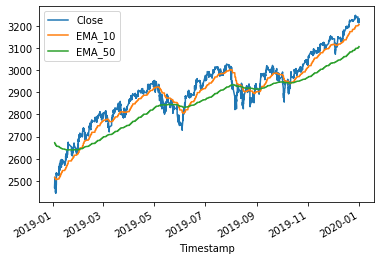

In [22]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'EMA_10', 'EMA_50'])

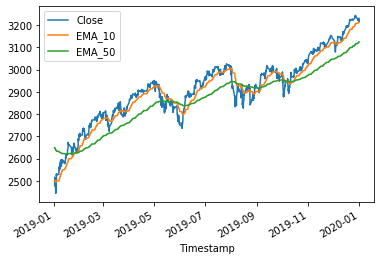

In [23]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'EMA_10', 'EMA_50'])

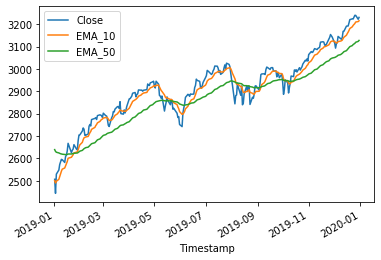

In [24]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'EMA_10', 'EMA_50'])

### Relative Strength Index

In [25]:
full['RSI'] = ta.momentum.rsi(full['Close'], n=14*60*8, fillna=False)

hour['RSI'] = ta.momentum.rsi(hour['Close'], n=14*8, fillna=False)

day['RSI'] = ta.momentum.rsi(day['Close'], n=14, fillna=False)

In [26]:
#full.head(20)
#hour.head(20)
#day.head(20)

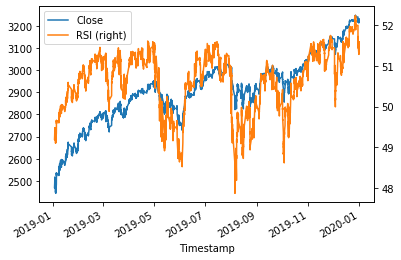

In [27]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'RSI'], secondary_y=['RSI'])

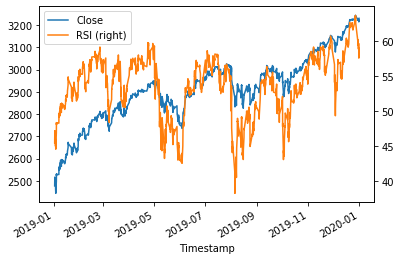

In [28]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'RSI'], secondary_y=['RSI'])

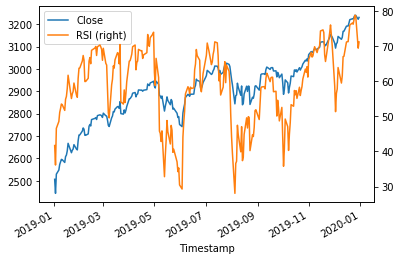

In [29]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'RSI'], secondary_y=['RSI'])

### Rate of Change

In [30]:
full['ROC'] = ta.momentum.roc(full['Close'], n=12*60*8, fillna=False)

hour['ROC'] = ta.momentum.roc(hour['Close'], n=12*8, fillna=False)

day['ROC'] = ta.momentum.roc(day['Close'], n=12, fillna=False)

In [31]:
#full.head(20)
#hour.head(20)
#day.head(20)

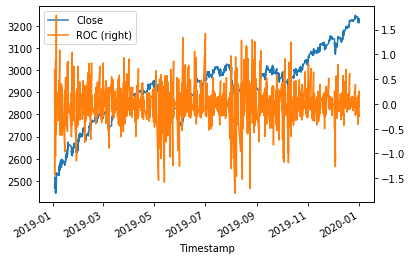

In [32]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'ROC'], secondary_y=['ROC'])

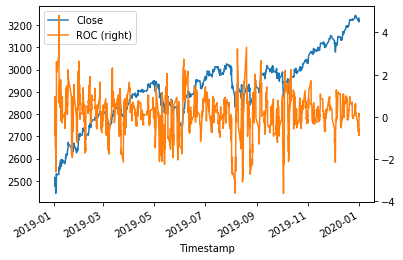

In [33]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'ROC'], secondary_y=['ROC'])

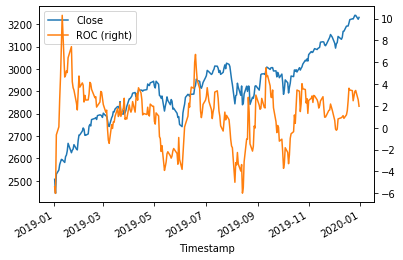

In [34]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'ROC'], secondary_y=['ROC'])

### MACD

In [35]:
macd_full = ta.trend.MACD(full['Close'],
                     n_slow = 50*60*8, 
                     n_fast = 10*60*8,
                     n_sign = 9, 
                     fillna = False)

full['MACD_Line'] = macd_full.macd()
full['MACD_Diff'] = macd_full.macd_diff()
full['MACD_Sig'] = macd_full.macd_signal()
#full.head(50)

In [36]:
macd_hour = ta.trend.MACD(hour['Close'],
                     n_slow = 50*8, 
                     n_fast = 10*8,
                     n_sign = 9, 
                     fillna = False)

hour['MACD_Line'] = macd_hour.macd()
hour['MACD_Diff'] = macd_hour.macd_diff()
hour['MACD_Sig'] = macd_hour.macd_signal()
#hour.head(50)

In [37]:
macd_day = ta.trend.MACD(day['Close'],
                     n_slow = 50, 
                     n_fast = 10,
                     n_sign = 9, 
                     fillna = False)

day['MACD_Line'] = macd_day.macd()
day['MACD_Diff'] = macd_day.macd_diff()
day['MACD_Sig'] = macd_day.macd_signal()
#day.head(50)

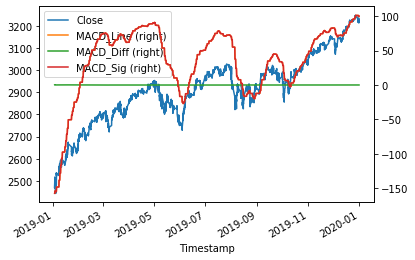

In [38]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'MACD_Line', 'MACD_Diff', 'MACD_Sig'],
                                            secondary_y=['MACD_Line', 'MACD_Diff', 'MACD_Sig'])

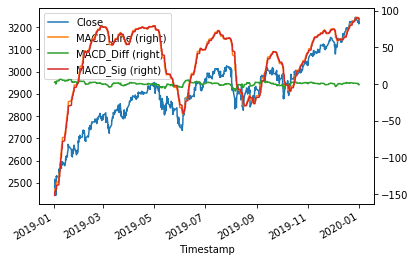

In [39]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'MACD_Line', 'MACD_Diff', 'MACD_Sig'],
                                            secondary_y=['MACD_Line', 'MACD_Diff', 'MACD_Sig'])

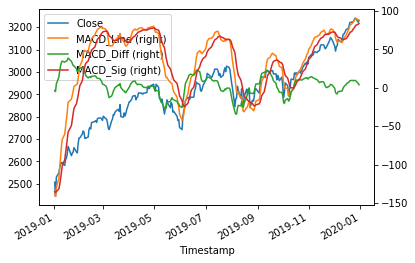

In [40]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'MACD_Line', 'MACD_Diff', 'MACD_Sig'],
                                            secondary_y=['MACD_Line', 'MACD_Diff', 'MACD_Sig'])

### Williams Oscillator

In [41]:
wo_full = ta.momentum.UltimateOscillator(full['High'],
                                    full['Low'],
                                    full['Close'],
                                    s = 7, 
                                    m = 14, 
                                    len = 28, 
                                    ws = 4.0, 
                                    wm = 2.0,
                                    wl = 1.0, 
                                    fillna = False)

full['WO'] = wo_full.uo()

In [42]:
wo_hour = ta.momentum.UltimateOscillator(hour['High'],
                                    hour['Low'],
                                    hour['Close'],
                                    s = 7, 
                                    m = 14, 
                                    len = 28, 
                                    ws = 4.0, 
                                    wm = 2.0,
                                    wl = 1.0, 
                                    fillna = False)

hour['WO'] = wo_hour.uo()

In [43]:
wo_day = ta.momentum.UltimateOscillator(day['High'],
                                    day['Low'],
                                    day['Close'],
                                    s = 7, 
                                    m = 14, 
                                    len = 28, 
                                    ws = 4.0, 
                                    wm = 2.0,
                                    wl = 1.0, 
                                    fillna = False)

day['WO'] = wo_day.uo()

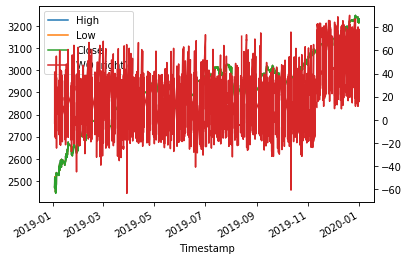

In [44]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'WO'], secondary_y=['WO'])

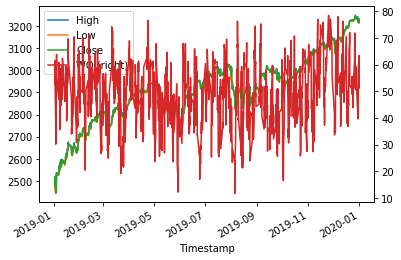

In [45]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'WO'], secondary_y=['WO'])

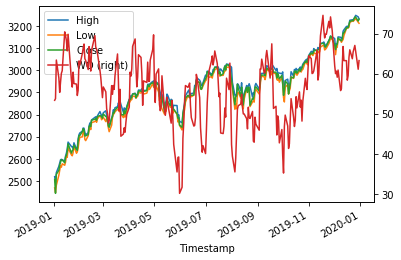

In [46]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'WO'], secondary_y=['WO'])

### Average True Range

In [47]:
atr_full = ta.volatility.AverageTrueRange(full['High'], 
                                     full['Low'], 
                                     full['Close'], 
                                     n = 14*60*8, 
                                     fillna = False)

full['ATR'] = atr_full.average_true_range()

In [48]:
atr_hour = ta.volatility.AverageTrueRange(hour['High'], 
                                     hour['Low'], 
                                     hour['Close'], 
                                     n = 14*8, 
                                     fillna = False)

hour['ATR'] = atr_hour.average_true_range()

In [49]:
atr_day = ta.volatility.AverageTrueRange(day['High'], 
                                     day['Low'], 
                                     day['Close'], 
                                     n = 14, 
                                     fillna = False)

day['ATR'] = atr_day.average_true_range()

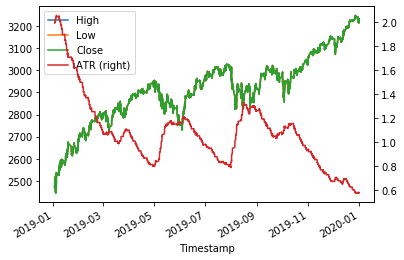

In [50]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ATR'], secondary_y=['ATR'])

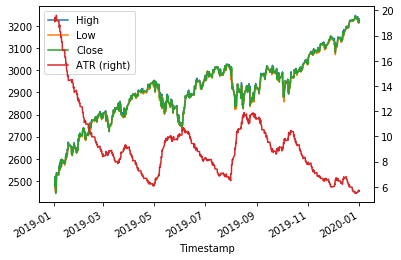

In [51]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ATR'], secondary_y=['ATR'])

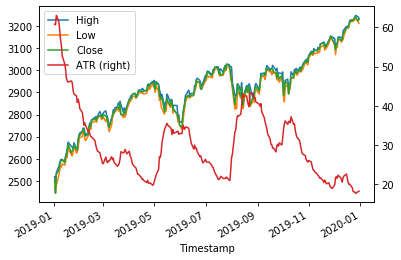

In [52]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ATR'], secondary_y=['ATR'])

### Check everything looks right

In [53]:
print('Shape of Minute Resolution:',full.shape)
print('Shape of Hour Resolution:',hour.shape)
print('Shape of Day Resolution:',day.shape)

Shape of Minute Resolution: (1498110, 16)
Shape of Hour Resolution: (30754, 16)
Shape of Day Resolution: (3857, 16)


In [54]:
print(full.columns)
print(hour.columns)
print(day.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'SMA_10', 'SMA_50',
       'EMA_10', 'EMA_50', 'RSI', 'ROC', 'MACD_Line', 'MACD_Diff', 'MACD_Sig',
       'WO', 'ATR'],
      dtype='object')
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'SMA_10', 'SMA_50',
       'EMA_10', 'EMA_50', 'RSI', 'ROC', 'MACD_Line', 'MACD_Diff', 'MACD_Sig',
       'WO', 'ATR'],
      dtype='object')
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'SMA_10', 'SMA_50',
       'EMA_10', 'EMA_50', 'RSI', 'ROC', 'MACD_Line', 'MACD_Diff', 'MACD_Sig',
       'WO', 'ATR'],
      dtype='object')


In [55]:
#Check everything looks right

#full.tail(50)
#hour.tail(50)
#day.tail(50)

In [56]:
#full.describe()
#hour.describe()
#day.describe()

## PCA

In [57]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [58]:
X = day.drop(['Close', 'Timestamp'], axis=1)
y = day['Close']

In [59]:
#X['Timestamp'] = X['Timestamp'].astype(np.int64)
#X.head(3).dropna(inplace=True)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [61]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [63]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [64]:
explained_variance = pca.explained_variance_ratio_

In [65]:
explained_variance

array([7.70474117e-01, 1.43967569e-01, 5.58890819e-02, 1.15086647e-02,
       1.07828547e-02, 5.18214798e-03, 2.10368310e-03, 5.18817344e-05,
       2.15995578e-05, 9.97348948e-06, 6.30468674e-06, 2.12243531e-06,
       4.44376213e-33, 3.73030833e-33])

In [66]:
labels = day.drop(['Close', 'Timestamp'], axis=1).columns
labels

Index(['Open', 'High', 'Low', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI',
       'ROC', 'MACD_Line', 'MACD_Diff', 'MACD_Sig', 'WO', 'ATR'],
      dtype='object')

In [67]:
series = pd.Series(explained_variance)

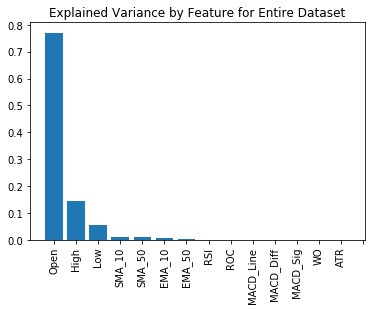

In [68]:
ax = plt.bar(labels, series)
plt.xticks(range(0, len(series)+1), labels, rotation=90)
plt.title('Explained Variance by Feature for Entire Dataset')
plt.show()

In [69]:
#split the PCA by year and see if things are persistent

In [70]:
#Don't forget to try a PCA on the transformed Supervised Learning dataset too

#https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

## Export the cleaned data to a csv

In [71]:
if True:
    full.to_csv('Clean Data/SPX500_Clean_Minute.csv')

In [72]:
if True:
    hour.to_csv('Clean Data/SPX_500_Clean_Hour.csv')

In [73]:
if True:
    day.to_csv('Clean Data/SPX_500_Clean_Day.csv')

## Appendix / References

In [74]:
#import plotly.graph_objects as go
#https://plot.ly/python/ohlc-charts/

In [75]:
# Clean up Data

# Remove the few weird days in there
# Sort out why the stock was trading between $10 and $20 for some short periods
# Sort out the High Price being lower than the Low price in 2018
# Fill in Gaps in Timestamps with a duplicate row of data in previous row. Otherwise using the index row won't work
# Do I need to scale the data?

In [76]:
# Create an evenly spaced datetime index from start to finish
# Filter by day of the week (ie. no weekends)
# Remove public holidays using a table of US public holidays
# Filter the time for half trading days by manually looking for "short" trading days by count or timestamps after 1pm
# Filter the remaining days for 0930 to 1600
# Vlookup data to fill each timestamp

In [77]:
#Testing

#df4 = df3[df3.Timestamp < '01/01/2001']
#full_test = full[full.Timestamp < '01/01/2001']
#df4.Timestamp[0]
#tsss = df4.Timestamp.to_numpy()
#df4.Timestamp[2] in tsss

In [78]:
# Create a function to set all filled timestamps volume to zero
#
#def fill_zeros(row, query_list):
#    '''function takes in a row and checks if timestamp is in the original dataframe (df3)
#       if the timestamp is in list, it returns the volume
#       if the timestamp is not in list, it replaces volume with zero (as it's been filled by merge_asof)
#    '''
#    # get the timestamp, ts from the row
#    ts = row['Timestamp']
#    
#    #check if it's in the query_list
#    if ts in query_list:
#        volume = row['Volume']
#    else:
#        volume = 0
#    
#    return volume

In [79]:
# Apply the function to the full dataframe
#import numpy as np
#from tqdm import tqdm
#
#tqdm.pandas()
#
#full['New_Volume'] = full.progress_apply(fill_zeros, axis=1, query_list=tss)
#full.head(10)

In [80]:
#lambda seemed to be quicker....but not much
#
#tqdm.pandas()
#full['New_Volume'] = full.progress_apply(lambda x: x['Volume'] if x['Timestamp'] in tss else 0, axis=1, raw=True)
#full.head(10)